In [1]:
! pip install torch torchvision transformers

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer
from transformers import BertModel
from PIL import Image
import requests
from io import BytesIO
import torch.optim as optim
import torch.nn as nn
import os
import pickle
from torchvision import models
from PIL import Image
import torch.nn.functional as F

In [3]:
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image
import requests
from io import BytesIO

In [4]:
df = pd.read_csv('coco_predictions.csv')
df.head()

,coco_url,captions,curious,amazed,fear,awe,neutral,disgusted,worried,intrigued,...,upset,concerned,good,hopeful,anger,joy,interested,calm,bored,scared
0,http://images.cocodataset.org/train2017/000000...,['A man with a red helmet on a small moped on ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,http://images.cocodataset.org/train2017/000000...,['A woman wearing a net on her head cutting a ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,http://images.cocodataset.org/train2017/000000...,['A child holding a flowered umbrella and pett...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,http://images.cocodataset.org/train2017/000000...,['A young boy standing in front of a computer ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,http://images.cocodataset.org/train2017/000000...,['a boy wearing headphones using one computer ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [5]:
class SimpleMultimodalModel(nn.Module):
    def __init__(self, num_classes, embedding_dim=128):
        super(SimpleMultimodalModel, self).__init__()

        # Text encoder: Embedding layer + GRU
        self.embedding = nn.Embedding(30522, embedding_dim)  # Using 30522 for BERT's Base uncased tokenizer
        self.gru = nn.GRU(embedding_dim, 256, batch_first=True)

        # Image encoder: Simplified CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fusion layer and classifier
        self.fc1 = nn.Linear(64 + 256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Process text input through embedding and GRU
        x_text = self.embedding(input_ids)
        _, x_text = self.gru(x_text)
        x_text = x_text.squeeze(0)  # Remove sequence dimension

        # Process images through simplified CNN
        x_img = F.relu(self.conv1(images))
        x_img = F.relu(self.conv2(x_img))
        x_img = F.relu(self.conv3(x_img))
        x_img = self.adaptive_pool(x_img)
        x_img = torch.flatten(x_img, 1)  # Flatten all dimensions except batch

        # Fusion and classification
        combined_features = torch.cat((x_img, x_text), dim=1)
        fused_features = F.relu(self.fc1(combined_features))
        logits = self.fc2(fused_features)

        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(logits)
        
        return probabilities

In [6]:
class CocoCaptionsDataset(Dataset):
    def __init__(self, dataframe, transform=None, tokenizer=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_url = row['coco_url']
        caption = eval(row['captions'])[0]  # Evaluating the string to get the list and taking the first item

        # Image processing
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')  # Convert image to RGB
        if self.transform:
            image = self.transform(image)

        # Text processing
        inputs = self.tokenizer(caption, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
        input_ids, attention_mask = inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0)

        # Labels - extracting the last 29 columns as classes
        labels = torch.tensor(row[2:].values.astype(float), dtype=torch.float32)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'images': image}, labels


In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image(url):
    # Load image from URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

def prepare_text(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs['input_ids'], inputs['attention_mask']

In [8]:
# Initialize model, optimizer, and loss function
model = SimpleMultimodalModel(num_classes=29)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

In [9]:
# Process 3 examples from the DataFrame to see if the probabilies are correct
for index, row in df.head(3).iterrows():
    image_url = row['coco_url']
    caption = eval(row['captions'])[0]

    # Preprocess the image and text
    image_tensor = preprocess_image(image_url)
    input_ids, attention_mask = prepare_text(caption)

    # Forward pass through the model
    probabilities = model(input_ids, attention_mask, image_tensor)

    # Convert logits to probabilities and print (optional sigmoid and thresholding could be added)
    print(f"Example {index + 1}:")
    print(probabilities)

Example 1:
tensor([[0.5038, 0.5210, 0.5077, 0.5263, 0.5177, 0.5170, 0.4992, 0.4819, 0.5055,
         0.4845, 0.4903, 0.4874, 0.4977, 0.4931, 0.5076, 0.4942, 0.5002, 0.4918,
         0.5106, 0.4993, 0.4902, 0.4837, 0.5137, 0.4561, 0.5020, 0.4901, 0.4971,
         0.4974, 0.4875]], grad_fn=<SigmoidBackward0>)
Example 2:
tensor([[0.5084, 0.5269, 0.5092, 0.5182, 0.5200, 0.5087, 0.4996, 0.4853, 0.5022,
         0.4815, 0.4859, 0.4917, 0.5016, 0.4980, 0.5075, 0.4933, 0.5003, 0.4912,
         0.5020, 0.5018, 0.4885, 0.4844, 0.5170, 0.4604, 0.5030, 0.4955, 0.4916,
         0.4948, 0.4853]], grad_fn=<SigmoidBackward0>)
Example 3:
tensor([[0.5037, 0.5241, 0.5071, 0.5230, 0.5193, 0.5137, 0.4933, 0.4837, 0.5014,
         0.4812, 0.4855, 0.4850, 0.5041, 0.4955, 0.5103, 0.4940, 0.4991, 0.4866,
         0.5089, 0.5034, 0.4949, 0.4835, 0.5131, 0.4638, 0.5015, 0.4961, 0.4904,
         0.4981, 0.4864]], grad_fn=<SigmoidBackward0>)


In [10]:
checkpoint_path = "student_checkpoint.pth.tar"

import pickle

log_file_path = './student_log.pickle'

In [11]:
def save_checkpoint(model, optimizer, epoch, batch, loss):
    torch.save({
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

    with open(log_file_path, 'wb') as f:
        pickle.dump(log, f)
        
def load_checkpoint(model, optimizer):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        start_batch = checkpoint.get('batch', 0)  # default to 0 if not present
        loss = checkpoint['loss']
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}, batch {start_batch}")

        with open(log_file_path, 'rb') as f:
            log = pickle.load(f)
        return start_epoch, start_batch, loss, log
    else:
        print("No checkpoint found. Starting from epoch 1")
        return 0, 0, None, {'epoch':[], 'loss':[]}

In [12]:
start_epoch, start_batch, previous_loss, log = load_checkpoint(model, optimizer)

No checkpoint found. Starting from epoch 1


In [13]:
start_epoch, start_batch, previous_loss, log

(0, 0, None, {'epoch': [], 'loss': []})

In [14]:
# Sample 10% of the data
sampled_df = df.sample(frac=0.1, random_state=42)  # Ensures reproducibility

# Proceed with dataset and dataloader setup
sampled_dataset = CocoCaptionsDataset(sampled_df, transform=transform, tokenizer=tokenizer)
sampled_dataloader = DataLoader(sampled_dataset, batch_size=64, shuffle=False)

In [15]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
num_epochs = 1
running_losses = []

In [17]:
for epoch in range(start_epoch, num_epochs):
    running_loss = 0.0 if epoch > start_epoch or start_batch == 0 else previous_loss

    remaining_batches = len(sampled_dataloader) - start_batch if epoch == start_epoch else len(sampled_dataloader)
    pbar = tqdm(total=remaining_batches, initial=start_batch, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, batch in enumerate(sampled_dataloader):
        # Process the current batch
        inputs, labels = batch
        optimizer.zero_grad()
        logits = model(inputs['input_ids'], inputs['attention_mask'], inputs['images'])
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_losses.append(loss.item())

        # Update progress bar description dynamically
        pbar.set_description(f"Epoch {epoch+1}, Loss: {running_loss / (i+1-start_batch):.4f}")

        # Update progress bar manually for processed batches
        pbar.update(1)

        if i % 2 == 1:
            save_checkpoint(model, optimizer, epoch, i, running_loss / (i+1-start_batch))

    # After processing all batches, update progress bar to the end
    pbar.close()

    average_loss = running_loss / (len(sampled_dataloader) - start_batch if epoch == start_epoch else len(sampled_dataloader))
    print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")
    log['epoch'].append(epoch + 1)
    log['loss'].append(average_loss)
    save_checkpoint(model, optimizer, epoch, len(sampled_dataloader)-1, average_loss)

    start_batch = 0  # Reset start batch for subsequent epochs

print("Training completed.")

Epoch 1, Loss: 0.6640: 100%|████████████| 185/185 [1:06:38<00:00, 21.61s/it]


Epoch 1, Average Loss: 0.6640
Training completed.


In [18]:
torch.save(model.state_dict(), "trained_student_model.pth")

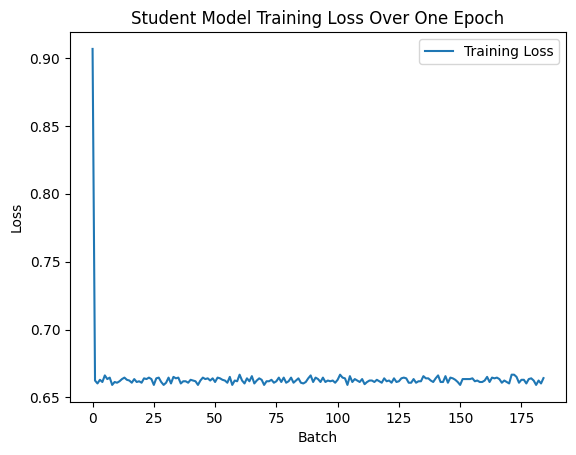

In [19]:
plt.plot(range(len(running_losses)), running_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Student Model Training Loss Over One Epoch')
plt.legend()
plt.show()